### Setting-up environment

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

!unzip -q "/content/drive/MyDrive/ColabNotebooks/icml_face_data.zip" -d /content/icml

import os
os.listdir("/content")

Mounted at /content/drive


['.config', 'icml', 'drive', 'sample_data']

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd

print(tf.__version__)

# Set hyperparameters (determined below)
LR = 3e-4
EPOCHS = 1000 #batch normalisation allows us to train in less epochs (vs 2500 before)
BATCH_SIZE = 256

2.19.0


# Emotion detection with CNN custom

This notebook aims to design and develop a deep learning model for facial emotion recognition, to be used as a central component within the Face & Emotion Detection project developed in C++. The basic idea is to initially build a working model in Python using Keras/TensorFlow, with the main goal of obtaining a reliable classifier that can be exported and subsequently integrated into the system developed in C++

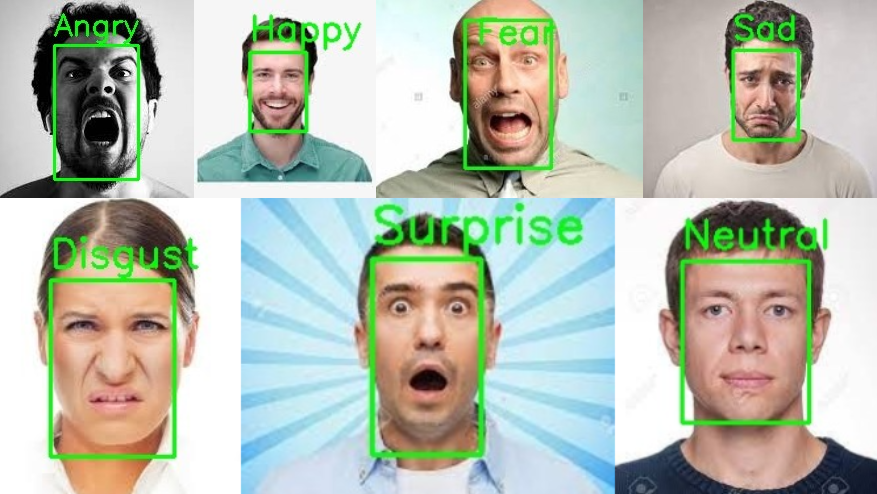

This project focuses on creating a comprehensive and reproducible workflow that includes:
- defining a custom CNN architecture capable of classifying facial expressions into seven categories (angry, disgust, fear, happy, sad, surprise, neutral);

- the use of pre-processing and data augmentation techniques to improve the robustness of the model in real conditions;

- training and evaluating the model using standard metrics such as accuracy, precision, recall, F1-score and confusion matrix;

- saving the model in portable format (.h5), so as to allow its subsequent conversion (in a dedicated notebook) into .pb format


**Author:** *Spicoli Piersilvio*

## Exploring the dataset

The data was sourced from the FER2013 Facial Expression Recognition dataset, which was initially presented as a Kaggle competition: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data. This dataset consists of 48x48 grayscale images of faces, each with one of 7 facial expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set contained 28,709 images while the public and private test sets each contained 3,589 images. For our experiments we used the public test set as our validation set and the private test set as our testing set

In [5]:
raw_data = pd.read_csv("icml/icml_face_data.csv")
raw_data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
raw_np = raw_data.values
print("dataset shape: ", raw_np.shape)

dataset shape:  (35887, 3)


few images for 'Disgust' class...

/tmp/ipython-input-595937186.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


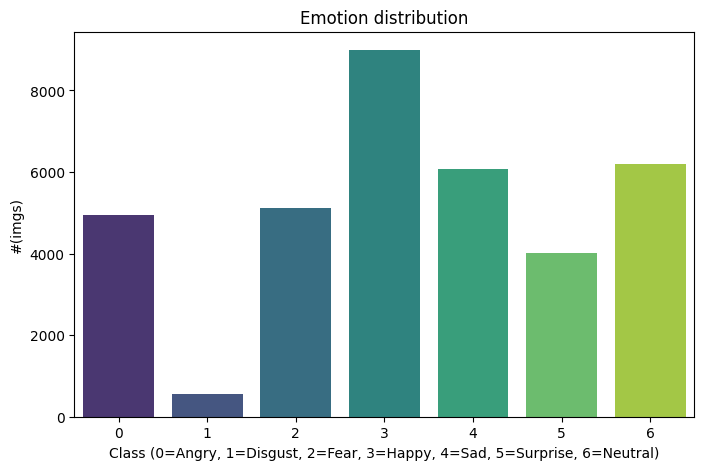

,count
emotion,
0,4953
1,547
2,5121
3,8989
4,6077
5,4002
6,6198


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = raw_data['emotion'].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Emotion distribution")
plt.xlabel("Class (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)")
plt.ylabel("#(imgs)")
plt.show()

class_counts

## Data Pre-processing and Augmentation

This instruction converts the raw pixel strings from the FER2013 dataset into normalized image arrays ready for model training. Specifically, each entry in the "pixels" column is a long string of 2304 numbers (corresponding to a 48×48 grayscale image). The code splits each string into individual values, converts them into integers, and reshapes the sequence into a 48×48 matrix representing the image. All images are then stacked into a NumPy array and normalized by dividing pixel values by 255.0, ensuring that intensity values lie in the [0,1] range

At the same time, the "emotion" column is extracted and converted into integers, providing the target labels for classification. As a result, the variable images contains the preprocessed grayscale input images, while labels stores the corresponding emotion categories

In [14]:
images = np.array([np.reshape([int(s) for s in pic.split(' ')], (48,48)) for pic in raw_np[:,2]])/255.0
labels = raw_np[:,0].astype('int')

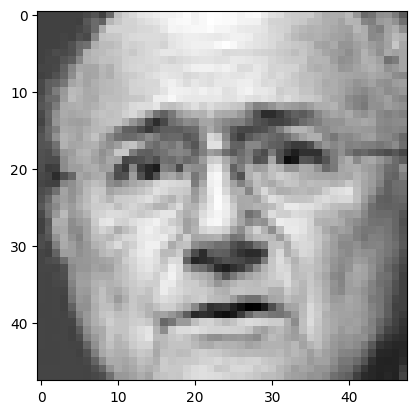

In [17]:
plt.imshow(images[5], cmap='gray')

splitting the dataset...

In [18]:
# Split Train, Test, Val
train_images = images[raw_np[:,1]=="Training"][...,np.newaxis]
valid_images = images[raw_np[:,1]=="PublicTest"][...,np.newaxis]
test_images = images[raw_np[:,1]=="PrivateTest"][...,np.newaxis]

train_labels = labels[raw_np[:,1]=="Training"]
valid_labels = labels[raw_np[:,1]=="PublicTest"]
test_labels = labels[raw_np[:,1]=="PrivateTest"]

In [19]:
train_labels

array([0, 0, 2, ..., 4, 0, 4])

In [20]:
train_images.shape

(28709, 48, 48, 1)

### Image Data Generator

An ImageDataGenerator is defined to perform data augmentation and feature-wise normalization on the training set. The augmentation parameters (rotation, zoom, shifts, shear, horizontal flip) generate new variations of the images to improve generalization and reduce overfitting. The options featurewise_center=True and featurewise_std_normalization=True standardize the data by subtracting the global mean and dividing by the standard deviation

In [21]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    featurewise_center=True,
    featurewise_std_normalization=True
    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_images)

In [22]:
# Apply the desired normalization and augumentation...
valid_images -= datagen.mean
valid_images /= datagen.std

test_images -= datagen.mean
test_images /= datagen.std

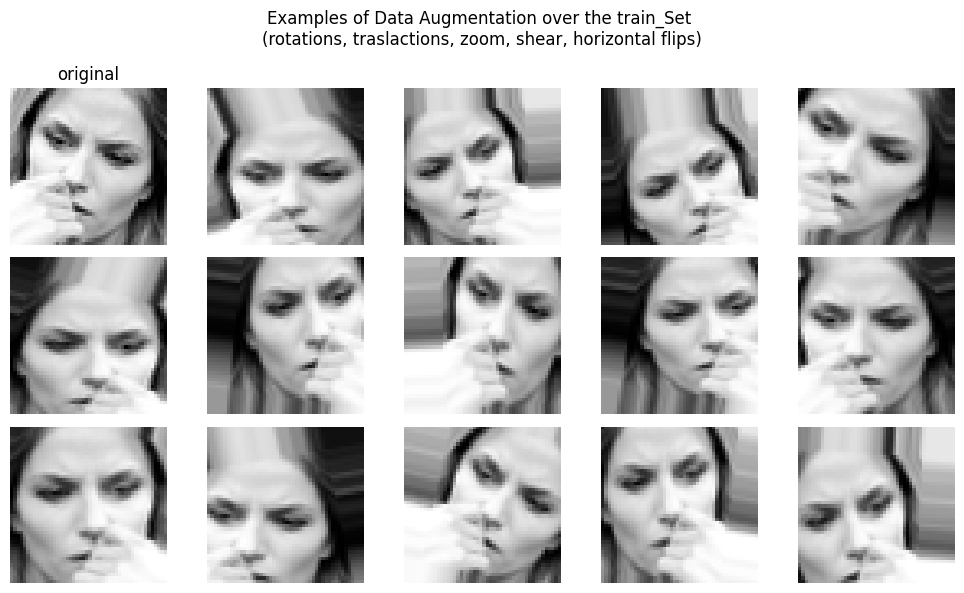

In [26]:
import numpy as np
import matplotlib.pyplot as plt

idx = 2  # class index
sample = train_images[idx]
if sample.ndim == 2:
    sample = sample[..., None]
sample = sample[np.newaxis, ...]   # (1,48,48,1)

fig = plt.figure(figsize=(10,6))
plt.subplot(3,5,1)
plt.imshow(sample[0, ..., 0], cmap='gray')
plt.axis('off')
plt.title('original')

i = 2
for batch in datagen.flow(sample, batch_size=1):
    plt.subplot(3,5, i)
    plt.imshow(batch[0, ..., 0], cmap='gray')
    plt.axis('off')
    i += 1
    if i > 15:
        break

plt.suptitle("Examples of Data Augmentation over the train_Set \n(rotations, traslactions, zoom, shear, horizontal flips)")
plt.tight_layout()
plt.show()


## Model Structure

The neural network used in this project is a **custom Convolutional Neural Network (CNN)**. This architecture is conceptually similar to early CNNs such as **LeNet-5**, but adapted with additional normalization and dropout layers to improve generalization. The input to the network is a 48×48 grayscale image with one channel.  

The architecture is structured as follows:  

- **Input layer**: accepts images of shape (48,48,1).  

- **First convolutional block**:  
  - Conv2D layer with 32 filters of size 3×3, ReLU activation and “same” padding.  
  - Batch Normalization to stabilize training.  
  - MaxPooling with a 2×2 kernel to reduce spatial dimensions.  
  - Dropout (0.25) to reduce overfitting.  

- **Second convolutional block**:  
  - Two consecutive Conv2D layers (32 filters, 3×3, ReLU, same padding).  
  - Batch Normalization.  
  - MaxPooling with a 2×2 kernel.  
  - Dropout (0.25).  

- **Fully connected block**:  
  - Flattening of feature maps.  
  - Dense layer with 512 units and ReLU activation.  
  - Batch Normalization.  
  - Dropout (0.5).  

- **Output layer**:  
  - Dense layer with 7 units and Softmax activation to classify the input into one of the seven emotion categories.  



In [ ]:
inputs = Input(shape=(48,48,1))
X = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
X = BatchNormalization()(X)
X = MaxPooling2D(pool_size=(2,2))(X)
X = Dropout(0.25)(X)

X = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(X)
X = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D(pool_size=(2,2))(X)
X = Dropout(0.25)(X)

X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
outputs = Dense(7, activation='softmax')(X)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,384,519 (9.10 MB)

 Trainable params: 2,383,367 (9.09 MB)

 Non-trainable params: 1,152 (4.50 KB)

## Train Model

In this step, we implement firtly a **Learning Rate Finder** to determine the most suitable learning rate for training the CNN.  
The procedure works as follows:

- A copy of the model is created and trained for a few epochs while the **learning rate is gradually increased** from a very small value (`1e-8`) up to a large one (`1e0`).  
- At each epoch, the current learning rate and the corresponding loss are recorded.  
- The resulting plot (`loss` vs. `learning rate`) shows how the model reacts to different learning rates.  

From the curve, we can identify the region where the loss decreases smoothly (before it diverges), which represents the optimal range for training.  
In our case, the recommended learning rate lies approximately between **7.85e-03 and 2.07e-02**, and a safe choice is around **1e-3 – 3e-3** for stable convergence

In [ ]:
# From https://www.kaggle.com/rivesunder/optimizing-learning-rate-in-keras
class lr_finder():

    def __init__(self,model,begin_lr=1e-8, end_lr=1e-1, num_epochs=10, period=5):
        # lr_finder generates learning schedules for finding upper and lower bounds on the best learning rate, as well as
        # a cyclical learning rate schedule based on those bounds
        self.period = period
        # make a copy of the model to train through a sweep of learning rates
        self.model = clone_model(model)

        # define bounds to sweep through
        self.begin_lr = np.log(begin_lr)/np.log(10)
        self.end_lr = np.log(end_lr)/np.log(10)
        self.num_epochs = num_epochs
        self.lower_bound = begin_lr
        self.upper_bound = 1e-2 #end_lr
        # define learning rates to use in schedules
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)


    def reset_model(self, model):
        # reset the model to find new lr bounds
        self.begin_lr = -10
        self.end_lr = 0
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.model = clone_model(model)

    def lr_schedule(self,epoch):
        # return lr according to a sweeping schedule
        if epoch < self.num_epochs:
            return self.lr[epoch]
        else:
            return self.lr[0]

    def clr_schedule(self,epoch,period=5):
        # return lr according to cyclical learning rate schedule
        my_epoch = int(epoch % self.period)
        return self.clr[my_epoch]

    def lr_vector(self,epochs):
        # return the vector of learning rates used in a schedule
        lrv = []
        for ck in range(epochs):
            lrv.append(self.lr_schedule(ck))
        return lrv

    def lr_plot(self,history_loss,please_plot=True):
        # plot the lr sweep results and set upper and lower bounds on learning rate
        x_axis = self.lr_vector(self.num_epochs)
        y_axis = history_loss

        d_loss = []
        for cc in range(1,len(y_axis)):
            if cc == 1:
                d_loss.append(y_axis[cc] - y_axis[cc-1])
            else:
                d_loss.append(0.8*(y_axis[cc] - y_axis[cc-1])+0.2*(y_axis[cc-1] - y_axis[cc-2]))
        d_loss = np.array(d_loss)

        self.lower_bound = x_axis[d_loss.argmin()]
        self.upper_bound = x_axis[np.array(y_axis).argmin()]
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)

        print("recommended learning rate: more than %.2e, less than %.2e "%(self.lower_bound, self.upper_bound))
        if(please_plot):
            plt.figure(figsize=(10,5))
            plt.loglog(x_axis,y_axis)
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.title('Loss / learning rate progression')
            plt.show()

    def get_lr(self,epoch):
        # return the geometric mean of the upper and lower bound learning rates
        return (self.lower_bound *self.upper_bound)**(1/2)

In [ ]:
# initialize learning rate finder callback

lrf = lr_finder(model,begin_lr=1e-8, end_lr=1e0, num_epochs=20)
lr_rate = LearningRateScheduler(lrf.lr_schedule)

In [ ]:
steps_per_epoch = int(len(train_labels) / BATCH_SIZE)
max_epochs = 20

lrf.model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

lr_history = lrf.model.fit(
    datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
    steps_per_epoch=int(steps_per_epoch / 20),
    validation_data=(valid_images, valid_labels),
    validation_steps=50,
    epochs=max_epochs,
    callbacks=[lr_rate],
    verbose=0
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


recommended learning rate: more than 7.85e-03, less than 2.07e-02 


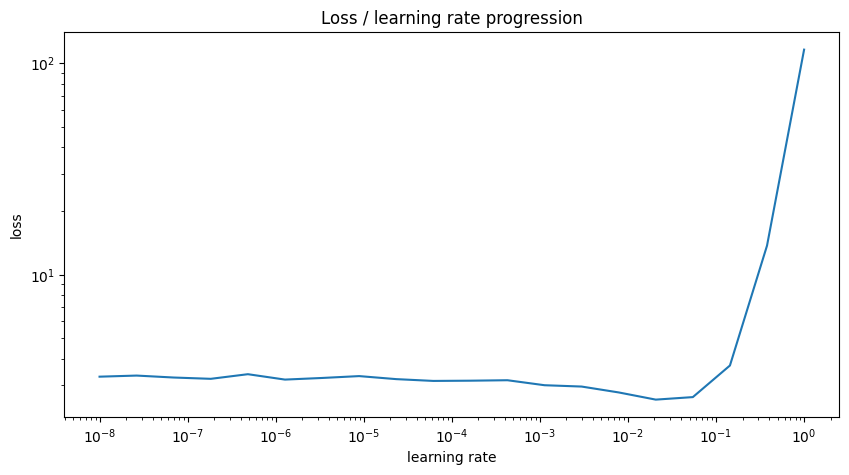

In [ ]:
lrf.lr_plot(lr_history.history['loss']) # probably use ~1e-4? (apparently 3e-4 is a rule of thumb that works well alot of the time; could also use a lr decay starting from 1e-3)

Then, the CNN model is compiled and trained on the FER2013 dataset.  
The **Adam optimizer** is used with the learning rate previously selected by the Learning Rate Finder, while the loss function is **sparse categorical crossentropy**, suitable for multi-class classification problems with integer labels. The model is evaluated using **accuracy** as the main metric.  The training is performed with the augmented dataset generated by the `ImageDataGenerator`, and the process is controlled by an **EarlyStopping callback** that monitors validation accuracy. Training automatically stops if no improvement is observed for 50 consecutive epochs, preventing overfitting and saving computational resources.  

During training, both the training and validation performance (accuracy and loss) are reported for each epoch, allowing us to monitor the learning progression of the network


In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=LR)

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_images) // BATCH_SIZE,
    validation_data=(valid_images, valid_labels),
    validation_steps=len(valid_images) // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=50)]
)


Epoch 1/1000
112/112 - 25s - 221ms/step - accuracy: 0.1875 - loss: 2.7217 - val_accuracy: 0.2327 - val_loss: 2.3884
Epoch 2/1000
112/112 - 0s - 2ms/step - accuracy: 0.1914 - loss: 2.3865 - val_accuracy: 0.2321 - val_loss: 2.3892
Epoch 3/1000


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


112/112 - 31s - 278ms/step - accuracy: 0.2158 - loss: 2.3182 - val_accuracy: 0.2602 - val_loss: 3.6087
Epoch 4/1000
112/112 - 0s - 1ms/step - accuracy: 0.2148 - loss: 2.2841 - val_accuracy: 0.2580 - val_loss: 3.6141
Epoch 5/1000
112/112 - 12s - 110ms/step - accuracy: 0.2352 - loss: 2.1445 - val_accuracy: 0.2549 - val_loss: 3.5153
Epoch 6/1000
112/112 - 0s - 1ms/step - accuracy: 0.2383 - loss: 2.0993 - val_accuracy: 0.2555 - val_loss: 3.5173
Epoch 7/1000
112/112 - 13s - 113ms/step - accuracy: 0.2445 - loss: 2.0405 - val_accuracy: 0.2775 - val_loss: 2.3914
Epoch 8/1000
112/112 - 0s - 2ms/step - accuracy: 0.2617 - loss: 2.0223 - val_accuracy: 0.2753 - val_loss: 2.3814
Epoch 9/1000
112/112 - 13s - 114ms/step - accuracy: 0.2583 - loss: 1.9546 - val_accuracy: 0.3034 - val_loss: 2.0042
Epoch 10/1000
112/112 - 0s - 2ms/step - accuracy: 0.2969 - loss: 1.8792 - val_accuracy: 0.3020 - val_loss: 2.0141
Epoch 11/1000
112/112 - 12s - 112ms/step - accuracy: 0.2695 - loss: 1.8987 - val_accuracy: 0.357

## Model Performance

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/"
model.save(path+'model_1000_15062020.h5')

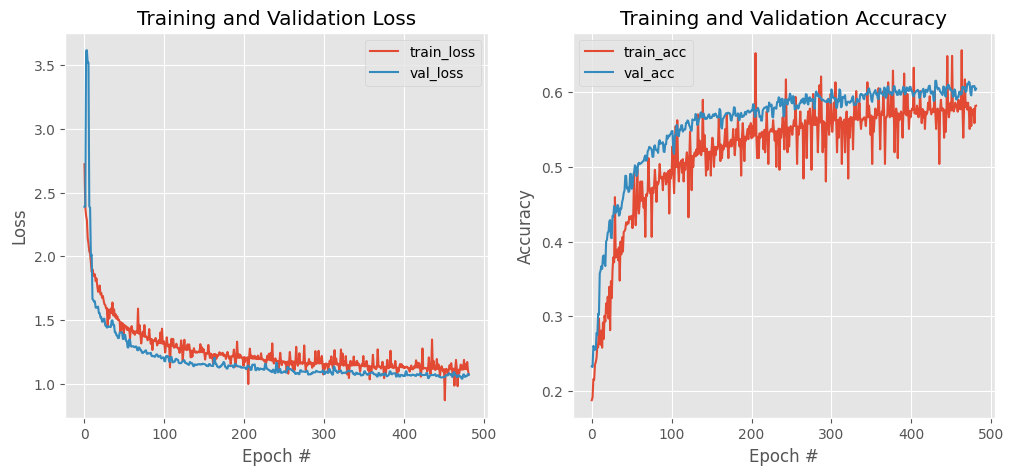

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


The plots above illustrate the training and validation curves for both **loss** and **accuracy** across epochs  

- **Loss curves**:  
  The training and validation loss both show a clear decreasing trend during the first epochs, stabilizing around a value close to 1.2. The fact that the two curves remain close to each other indicates that the model is not strongly overfitting, as validation loss follows the same trajectory as training loss without significant divergence

- **Accuracy curves**:  
  Accuracy steadily improves throughout training, reaching around **62% on the validation set**. Training accuracy shows more fluctuations, which is typical when using data augmentation, since the model is exposed to constantly changing variations of the input data. Validation accuracy, however, grows smoothly and stabilizes, confirming that the model generalizes reasonably well

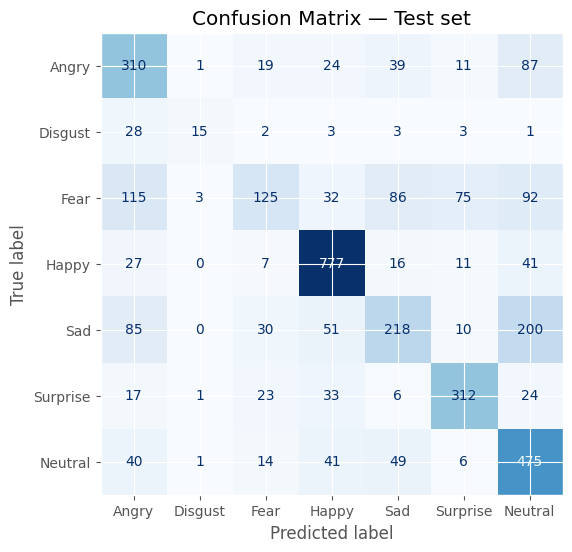

              precision    recall  f1-score   support

       Angry       0.50      0.63      0.56       491
     Disgust       0.71      0.27      0.39        55
        Fear       0.57      0.24      0.33       528
       Happy       0.81      0.88      0.84       879
         Sad       0.52      0.37      0.43       594
    Surprise       0.73      0.75      0.74       416
     Neutral       0.52      0.76      0.61       626

    accuracy                           0.62      3589
   macro avg       0.62      0.56      0.56      3589
weighted avg       0.62      0.62      0.60      3589



In [ ]:
# --- Confusion Matrix & Classification Report (Test set) ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predictions
try:
    y_pred = np.argmax(predIdxs, axis=1)
except NameError:
    pred_indices = model.predict(test_images, batch_size=BATCH_SIZE)
    y_pred = np.argmax(pred_indices, axis=1)

# Ground-truth labels (if one-hot encoded, take argmax)
y_true = test_labels if getattr(test_labels, "ndim", 1) == 1 else np.argmax(test_labels, axis=1)

# Class names
default_fer2013 = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
sorted_labels = np.unique(y_true)
if np.array_equal(sorted_labels, np.arange(len(default_fer2013))):
    label_names = default_fer2013
else:
    label_names = [str(l) for l in sorted_labels]

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=sorted_labels)

# Plot confusion matrix (counts)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot(
    ax=ax, cmap="Blues", values_format="d", colorbar=False
)
ax.set_title("Confusion Matrix — Test set")
plt.show()

# Per-class metrics (precision, recall, f1)
print(classification_report(y_true, y_pred, target_names=label_names))

The confusion matrix above shows the classification performance of the CNN on the test set. Each row represents the true label, while each column corresponds to the predicted label. The classification report provides precision, recall, and F1-score for each emotion class

- **Global accuracy**: The overall accuracy on the test set is approximately **62%**, consistent with the validation performance observed during training.  

- **Well-recognized classes**:  
  - *Happy* shows the best results, with high precision (0.81) and recall (0.88), confirming that the model effectively captures features associated with smiling expressions.  
  - *Surprise* also performs strongly (precision 0.73, recall 0.75), likely due to distinctive facial cues such as wide-open eyes and mouth.  

- **Moderate performance classes**:  
  - *Angry* and *Neutral* achieve moderate scores, with precision and recall around 0.50–0.63. These classes are sometimes confused with each other and with other negative emotions such as *Sad*.  

- **Challenging classes**:  
  - *Disgust* and *Fear* show the weakest performance, with low recall values (0.27 and 0.24, respectively). This is partly due to their low representation in the dataset (class imbalance) and the subtle differences between these emotions, which are more difficult for the model to distinguish.  
  - *Sad* also struggles, with an F1-score of 0.43, often misclassified as *Neutral* or *Angry*.  

- **Macro and weighted averages**:  
  - The macro F1-score is 0.56, highlighting variability in class-level performance.  
  - The weighted F1-score is 0.60, which better reflects the imbalanced dataset by weighting results according to class support


  

## Conclusion and future work

The model achieved an overall accuracy of **~62%** on the test set, which is in line with the difficulty of the dataset, characterized by low-resolution images, noisy labels, and strong class imbalance.  The analysis of the results highlights that:  
- The model performs best on classes with distinctive visual cues, such as **Happy** and **Surprise**, which achieved the highest precision and recall.  
- Classes with fewer samples or subtle differences, such as **Disgust**, **Fear**, and **Sad**, remain challenging and show significantly lower recall.  
- The model demonstrates **moderate generalization** ability, with training and validation curves progressing consistently and no signs of severe overfitting



**Future improvements** could include handling class imbalance with oversampling or class weighting, adopting deeper architectures such as ResNet or EfficientNet, applying transfer learning from larger face datasets, and performing extensive hyperparameter tuning (learning rate, batch size, dropout). Additionally, post-processing strategies and ensemble methods could be explored to further refine predictions and boost overall performance.
